### Biases as Diagonals
----

#### Diagonal zeros approach

Recall that the MPF cost function is given by:

$$K(\theta) = \frac{\epsilon}{|D|}\sum_{j \in D}\sum_{i\notin D}g_{ij}\exp\left(\frac{1}{2}(E_j(\theta)-E_i(\theta))\right)$$

with

$$E_i(\theta) = E_{x}(W,b) = -\frac{1}{2}x^TWx-bx$$

and the $W$ matrix being symmetric and having zeros as its diagonal entries. With some neat manipulation and using the properties of $W$, we managed to simply the cost function to a mere

$$K(\theta) = C \sum_{x \in D}\sum_{h=1}^{d}\exp\left[\left(1/2-x\right)_h(Wx+b)_h\right]$$

However, the diagonal of zeros seems to be causing some problems in the gradient descent portion of the learning; 

#### Biases as Diagonals

We now consider $W$ to be symmetric with the biases filled in the entries of the previously zero diagonals. Considering $x$ and $\tilde{x}$ be two states that are just one hop away,

$$E_{x}(\theta)-E_{\tilde{x}}(\theta) =-\frac{1}{2}x^TWx + \frac{1}{2}\tilde{x}^TW\tilde{x}$$

we can do a simple expansion which gives 

$$ \frac{1}{2}(\tilde{x}^TW\tilde{x} -\tilde{x}^TWx + \tilde{x}^TWx - x^TWx )$$

after some simplification we get

$$\frac{1}{2}z^TWy$$

where $z = \tilde{x} + x$ and $y = \tilde{x} -x$. Without loss of generality, let the following be given which $h$ being the index where the one hop occur,

$$\tilde{x}=\begin{pmatrix}x_1\\ \vdots\\ x_h\\ \vdots\\ x_n\end{pmatrix} \quad x = \begin{pmatrix}x_1\\ \vdots\\1-x_h\\ \vdots\\ x_n\end{pmatrix}$$

Expressing $z$ and $y$ explicitly, we have

$$z=\begin{pmatrix}2x_1\\ \vdots\\ 1\\ \vdots\\ 2x_n\end{pmatrix} \quad y = \begin{pmatrix}0\\ \vdots\\2x_h-1\\ \vdots\\ 0\end{pmatrix}$$


thus



$$\frac{1}{2}(E_{x}(\theta)-E_{\tilde{x}}(\theta)) = \frac{1}{4}z^TWy = \begin{pmatrix}x_1(x_h-1/2)W_{1h}, \ldots,1/2(x_h-1/2)W_{hh}\ldots,x_n(x_h-1/2)W_{nh} \end{pmatrix} $$

We can then factorize the common $x_h - 1/2$ term out and further simply the expression

$$\frac{1}{2}(E_{x}(\theta)-E_{\tilde{x}}(\theta))=\frac{1}{4}z^tWy = (x_h-1/2)\ast(W_{h1}x_1+...+W_{hn}x_n - W_{hh}x_h+ 1/2 W_{hh})$$

Let $Z = Wx$ and $\delta = x_h - 1/2$,

$$(x_h-1/2)*(Z_h - W_{hh}(x_h-1/2))\quad\text{where subscript $h$ means for row $h$}$$

$$\delta * Z - 1/4 * diag(W)\quad\text{ since } \delta^2 = 1/4$$


### Implementation
----

Using the samples created for the zero diagonals approach

In [2]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

import os
import timeit
from pathlib import Path
from datetime import datetime


%matplotlib inline

In [3]:
def load_data(dataset = '16-50K.npy', borrow = True):
    """
    Loads the dataset.
    """

    data = np.load(dataset)
    dataset = theano.shared(np.asarray(data, dtype = theano.config.floatX), borrow = borrow)

    return dataset

In [4]:
class mpf(object):
    """
    Minimum probability flow
    """
    
    def __init__(self, input = None, n = 32, temperature = 1,  W = None):
        
        self.n = n
        self.temperature = temperature
        U = np.random.rand(self.n, self.n)
        R = 0.5 * (U + U.T)
#         np.fill_diagonal(R, 0)

        if not W:
            initial_W = np.asarray(R, dtype = theano.config.floatX)
            W = theano.shared(initial_W, name = 'W', borrow = True)

#         if not b:
#             initial_b = np.asarray(np.random.rand(n), dtype = theano.config.floatX)
#             b = theano.shared(initial_b, name = 'b', borrow = True)


        self.W = W
#         self.b = b
        
        if input is None:
            self.x = T.dmatrix(name = 'input')
        else:
            self.x = input

        self.params = [self.W]
    
    
    def cost(self, lr = 1e-2, epsilon = 1):
        """
        Returns the cost of vanilla SGD. 
        The update rule enforces that the W matrix at each timestep is symmetric.
        """
         
        print (51 * '=')
        print (24 * '#' + 'MPF' + 24 * '#')
        print (51 * '=')
        print (str(datetime.now()))
        print ('Input size: {0}'.format(self.n))
        print ('Learning temperature: {0}'.format(self.temperature))
        print ('Learning rate: {0}'.format(lr))
        
        cost = T.mean(T.exp(((self.x - 0.5) * T.dot(self.x, self.W)) \
                            - .25 * (self.W - T.fill_diagonal(self.W, 0)))) * epsilon
#         cost = T.mean(T.exp((0.5 - self.x) * (T.dot(self.x, self.W) + self.b))) * epsilon
        Wgrad = T.grad(cost, self.W)

        Wupdate = 0.5 * ((self.W - lr * Wgrad) + (self.W - lr * Wgrad).T)
#         Wupdate = self.W - (lr * Wgrad)
        updates = [(self.W, Wupdate)]
#         bupdate = self.b - lr *(T.diag(0.5 * ((self.W - lr * Wgrad) + (self.W - lr * Wgrad).T)) + bgrad)
#         Wupdate = T.fill_diagonal(0.5 * ((self.W - lr * Wgrad) + (self.W - lr * Wgrad).T), 0)        
#         updates = [(self.W, Wupdate), (self.b, bupdate)]

        return cost, updates

In [12]:
def trainmpf(units = 32, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy'):
    """
    Trains parameters using MPF.
    """
    
    index = T.lscalar()
    x = T.matrix('x')
    flow = mpf(input = x, n = units, temperature = temperature)
    
    cost, updates = flow.cost(lr = lr, epsilon = epsilon)
    
    dataset = load_data(sample)
    n_dataset_batches = dataset.get_value(borrow = True).shape[0] // batchsize

    print ('Sample used: {0}'.format(sample))
    print ('=' * 51)
    
    mpf_cost = theano.function(inputs = [index], outputs = cost, updates = updates, \
                                givens = {x: dataset[index * batchsize: (index + 1) * batchsize]})
    
    start_time = timeit.default_timer()
    
    best_mse = np.inf
    best_W = [None, np.inf]
#     best_b = [None, np.inf]
    best_epoch = np.inf
    
    for epoch in range(n_epochs):
        c = []
        current_time = timeit.default_timer()
        for batch_index in range(n_dataset_batches):
            c.append(mpf_cost(batch_index))
        
        W_learnt = flow.W.get_value(borrow = True)
#         b_learnt = np.zeros((units, 1)) + np.diag(W_learnt)
        np.fill_diagonal(W_learnt, 0)
        
#         if not source:
#             W = np.load(sample[0:2] + '-' + 'W' + '.npy')
#             b = np.load(sample[0:2] + '-' + 'b' + '.npy')
#         else:    
#             W = np.load(source)
                        
#         b = np.diag(W).reshape(units, -1)
#         np.fill_diagonal(W, 0)

        W = np.load(sample[0:2] + '-' + 'Wnzd' + '.npy')
        
        mseW = np.linalg.norm(W - (-W_learnt))/ (units**2 - units)/2
#         mseb = np.linalg.norm(b - b_learnt)/ units
#         mse = (mseW * mseb)/(mseW + mseb)
#         mse = mseW + mseb
        
        if mseW < best_mse:
            best_mse = mseW
            best_W[0] = W_learnt  #flow.W.get_value(borrow = True)
            best_W[1] = mseW
#             best_b[0] = b_learnt  #flow.b.get_value(borrow = True)
#             best_b[1] = mseb
            best_cost = np.mean(c, dtype='float64')
            best_epoch = epoch
        
        if epoch%validate_every == 0:
            print ('Training epoch %d/%d, Cost: %f mseW: %.5f, Time Elasped: %.2f '\
                 % (epoch, n_epochs, np.mean(c, dtype='float64'), \
                 mseW,  (current_time - start_time)/60) )
    
    end_time = timeit.default_timer()

    training_time = end_time - start_time
    
    fig, ax = plt.subplots(figsize=(20,10))
    fig.tight_layout()
    plt.xticks(np.arange(0,100,16))
    
    ax.plot(W.reshape(-1,1)[0:100], 'b')
    ax.plot((-W_learnt).reshape(-1,1)[0:100], 'r')
    ax.plot(-best_W[0].reshape(-1,1)[0:100], 'g')
    ax.set_title('W')
    ax.legend(['W', 'Learnt W','Best W'])
#     ax[0].plot(W.reshape(-1,1)[0:100], 'b')
#     ax[0].plot((-W_learnt).reshape(-1,1)[0:100], 'r')
#     ax[0].plot(best_W[0].reshape(-1,1)[0:100], 'g')
#     ax[0].set_title('W')
#     ax[0].legend(['W', 'Learnt W','Best W'])
#     ax[1].plot(b.reshape(-1,1), 'b')
#     ax[1].plot(b_learnt.reshape(-1,1),'r')
#     ax[1].plot(best_b[0].reshape(-1,1),'g')
#     ax[1].set_title('b')
#     ax[1].legend(['b', 'Learnt b','Best b'])

    
    print ('The training took %.2f minutes' % (training_time/60.))
    print ('#' * 22 + 'Results' + '#' * 22)
    print ('=' * 51)
#     print ('Best mse: {0}'.format(mse))
    print ('Best W mse: {0}'.format(mseW))
#     print ('Best b mse: {0}'.format(mseb))
    print ('Best epoch: {0}'.format(best_epoch))
    print ('=' * 51)

Creating samples with non-zero diagonals

In [5]:
def getseed(n = 16, randstate = 123):
    """
    Generates the seed for the Gibbs sampler.
    Inputs:
    - n: (int) number of neurons in the network
    """
    prng = np.random.RandomState(randstate)
    return np.random.randint(2, size = n)

def getWnzd(n = 16, randstate = 123):
    """
    Generates the matrix to learn using MPF.
    Inputs:
    - n: (int) number of neurons in the network
    - index: if None, will be labeled by YearMonthDay-HourMinute
    """
    prng = np.random.RandomState(randstate)
    U = prng.normal(0, 1, (n, n))
    W = 0.5 * (U + U.T)

    filename = str(n) + '-' + 'Wnzd'
    myfile = Path(filename + '.npy')

    if myfile.is_file():
        print (filename + '.npy' + ' exists')
    else:
        np.save(filename, W)
        print ('W matrix saved as ' + filename + '.npy')  
    return W

In [6]:
def sigmoid(x):
    """
    Takes in a vector x and returns its sigmoid activation.
    Input:
    - x: a numpy array
    """
    return 1/(1 + np.exp(-x))


def one_state_update(x, W, s):
    """
    Does a single update of the sth neuron of the network.
    Inputs:
    - x: current state of the network to produce a new state
    - W: numpy array of weights
    - b: numpy array of biases
    """
    p = sigmoid(np.dot(W, x))
    new_x = np.zeros(x.shape) + x
    new_x[s] = np.random.binomial(1, p[s], 1)
    return new_x


def burn_in(x, W, n = 10000):
    """
    Performs the burning in before doing the Gibbs sampling.
    """
    v = x.shape[0]
    for i in range(n * v):
        s = np.random.randint(0, v)
        x = one_state_update(x, W, s)
    return x


def n_updates(x, W, n = 100):
    """
    Performs n times of the one_state_update.
    Inputs:
    - x: current state of the network to produce a new state
    - W: numpy array of weights
    - b: numpy array of biases
    - n: (int) number of updates to be made
    """
    v = x.shape[0]
    for i in range(n):
        s = np.random.randint(0, v)
        x = one_state_update(x, W, s)
    return x


def mixing(x, W, n = 50000, m = 100):
    """
    Does mixing for m times before obtaining a single sample.
    Inputs:
    - x: current state of the network to produce a new state
    - W: numpy array of weights
    - b: numpy array of biases
    - n: (int) number of samples to be generated
    - m: (int) number of updates before a sample is saved
    """
    samples = np.zeros((n, x.shape[0]))
    one = n // 100
    p = 1
    for i in range(n):
        # if i % one == 0:
        #     print ('%d %%' % p)
        #     p += 1
        x = n_updates(x, W, m)
        samples[i, :] = x
#     timestr = time.strftime('%Y%m%d-%H%M%S')
#     filename = 'sample'+timestr+'.dat'

#     if savesamples == "True":
#         np.save(filename, samples)
#         print ('Samples are saved as ' + filename)
#     elif savesamples == "False":
#         print ('Samples were not saved.')
#     else:
#         raise ValueError("savesamples must be 'True' or 'False'")
    return samples


def sampling(units = 16, n = 50000, m = 100, randstate = 123):
    """
    Generate n samples from seed x.
    Input:
    - units: (int) number of units in the Boltzmann machine
    - x: current state of the network to produce a new state
    - W: numpy array of weights
    - b: numpy array of biases
    - n: (int) number of samples to be generated
    - m: (int) number of updates before a sample is saved
    - savesamples: (bool)
    """
    K = n // 1000
    filename = str(units) + '-' + str(K) + 'K' + '-' + 'nzd'
    myfile = Path(filename + '.npy')

    if myfile.is_file():
        print (filename + '.npy' + ' exists.')
    else:
        tic = timeit.default_timer()

        print ('Generating %dK samples with %d units...' % (K, units))

        x = getseed(n = units, randstate = randstate)
        W = getWnzd(n = units, randstate = randstate)

        print ('Burning in...')
        burnt = burn_in(x, W)
        print ('Burnt:', burnt)
        print ('Mixing...')
        samples = mixing(burnt, W, n, m)
        
        np.save(filename, samples)
        print ('samples saved as ' + filename + '.npy')
        
        toc = timeit.default_timer()
        print ('Time taken to create %d samples is %.2f minutes' % (n, (toc - tic)/60.))
        return samples


In [7]:
sampling(units = 16, n = 50000, m = 100, randstate = 456)

16-50K-nzd.npy exists.


########################MPF########################
2017-04-07 13:50:17.150278
Input size: 16
Learning temperature: 1
Learning rate: 0.01
Sample used: 16-50K-nzd.npy
Training epoch 0/1000, Cost: 1.174218 mseW: 0.02276, Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.643085 mseW: 0.00857, Time Elasped: 0.38 
Training epoch 200/1000, Cost: 0.642939 mseW: 0.00840, Time Elasped: 0.76 
Training epoch 300/1000, Cost: 0.642936 mseW: 0.00839, Time Elasped: 1.13 
Training epoch 400/1000, Cost: 0.642936 mseW: 0.00839, Time Elasped: 1.49 
Training epoch 500/1000, Cost: 0.642936 mseW: 0.00839, Time Elasped: 1.84 
Training epoch 600/1000, Cost: 0.642936 mseW: 0.00839, Time Elasped: 2.25 
Training epoch 700/1000, Cost: 0.642936 mseW: 0.00839, Time Elasped: 2.64 
Training epoch 800/1000, Cost: 0.642936 mseW: 0.00839, Time Elasped: 2.99 
Training epoch 900/1000, Cost: 0.642936 mseW: 0.00839, Time Elasped: 3.35 
The training took 3.69 minutes
######################Results######################
Bes

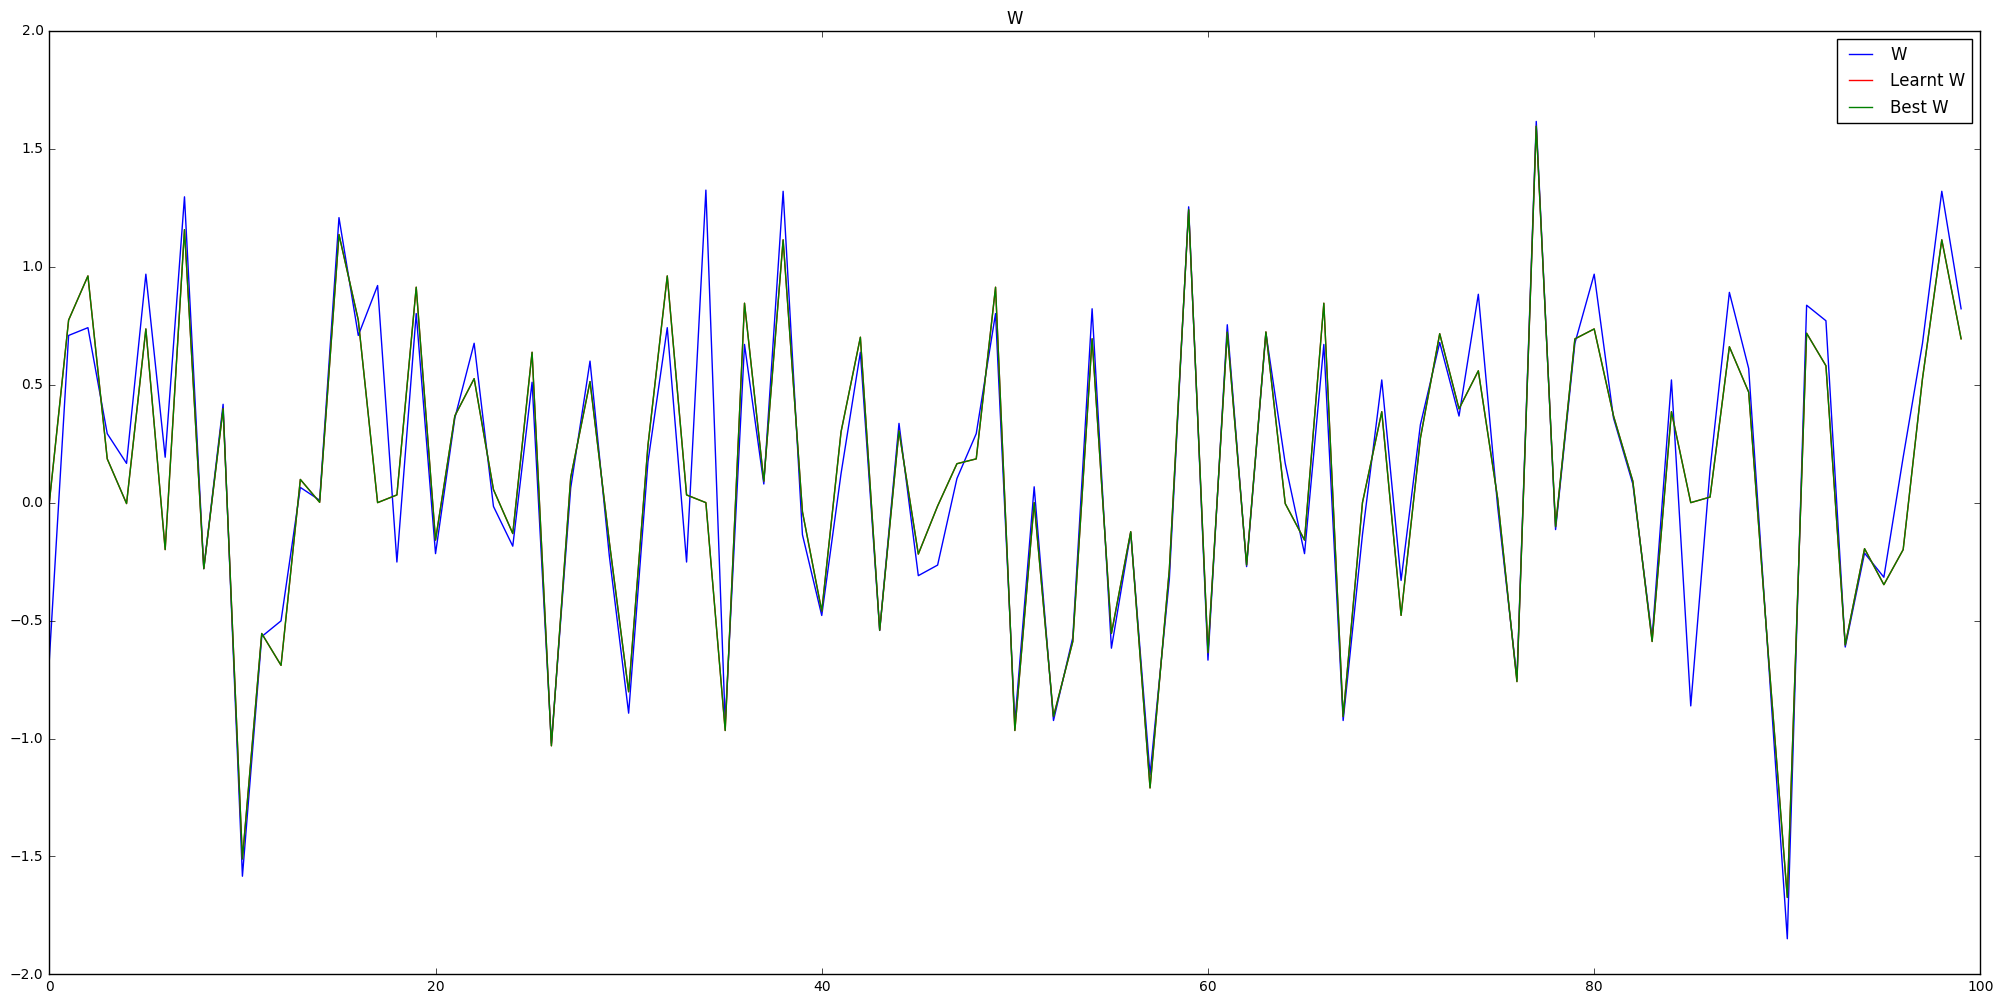

In [28]:
trainmpf(units = 16, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K-nzd.npy')

In [31]:
sampling(units = 32, n = 50000, m = 100, randstate = 456)

Generating 50K samples with 32 units...
W matrix saved as 32-Wnzd.npy
Burning in...
Burnt: [ 1.  0.  1.  1.  0.  0.  1.  1.  1.  1.  0.  0.  0.  1.  1.  1.  1.  0.
  1.  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.]
Mixing...
samples saved as 32-50K-nzd.npy
Time taken to create 50000 samples is 1.23 minutes


array([[ 1.,  0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  0.,  1.,  0.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

########################MPF########################
2017-04-07 14:14:52.213778
Input size: 32
Learning temperature: 1
Learning rate: 0.01
Sample used: 32-50K-nzd.npy
Training epoch 0/1000, Cost: 2.646108 mseW: 0.01139, Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.533572 mseW: 0.00786, Time Elasped: 0.32 
Training epoch 200/1000, Cost: 0.524624 mseW: 0.00667, Time Elasped: 0.63 
Training epoch 300/1000, Cost: 0.521610 mseW: 0.00599, Time Elasped: 0.94 
Training epoch 400/1000, Cost: 0.520176 mseW: 0.00554, Time Elasped: 1.25 
Training epoch 500/1000, Cost: 0.519357 mseW: 0.00522, Time Elasped: 1.56 
Training epoch 600/1000, Cost: 0.518835 mseW: 0.00497, Time Elasped: 1.87 
Training epoch 700/1000, Cost: 0.518476 mseW: 0.00477, Time Elasped: 2.18 
Training epoch 800/1000, Cost: 0.518218 mseW: 0.00462, Time Elasped: 2.48 
Training epoch 900/1000, Cost: 0.518024 mseW: 0.00449, Time Elasped: 2.80 
The training took 3.11 minutes
######################Results######################
Bes

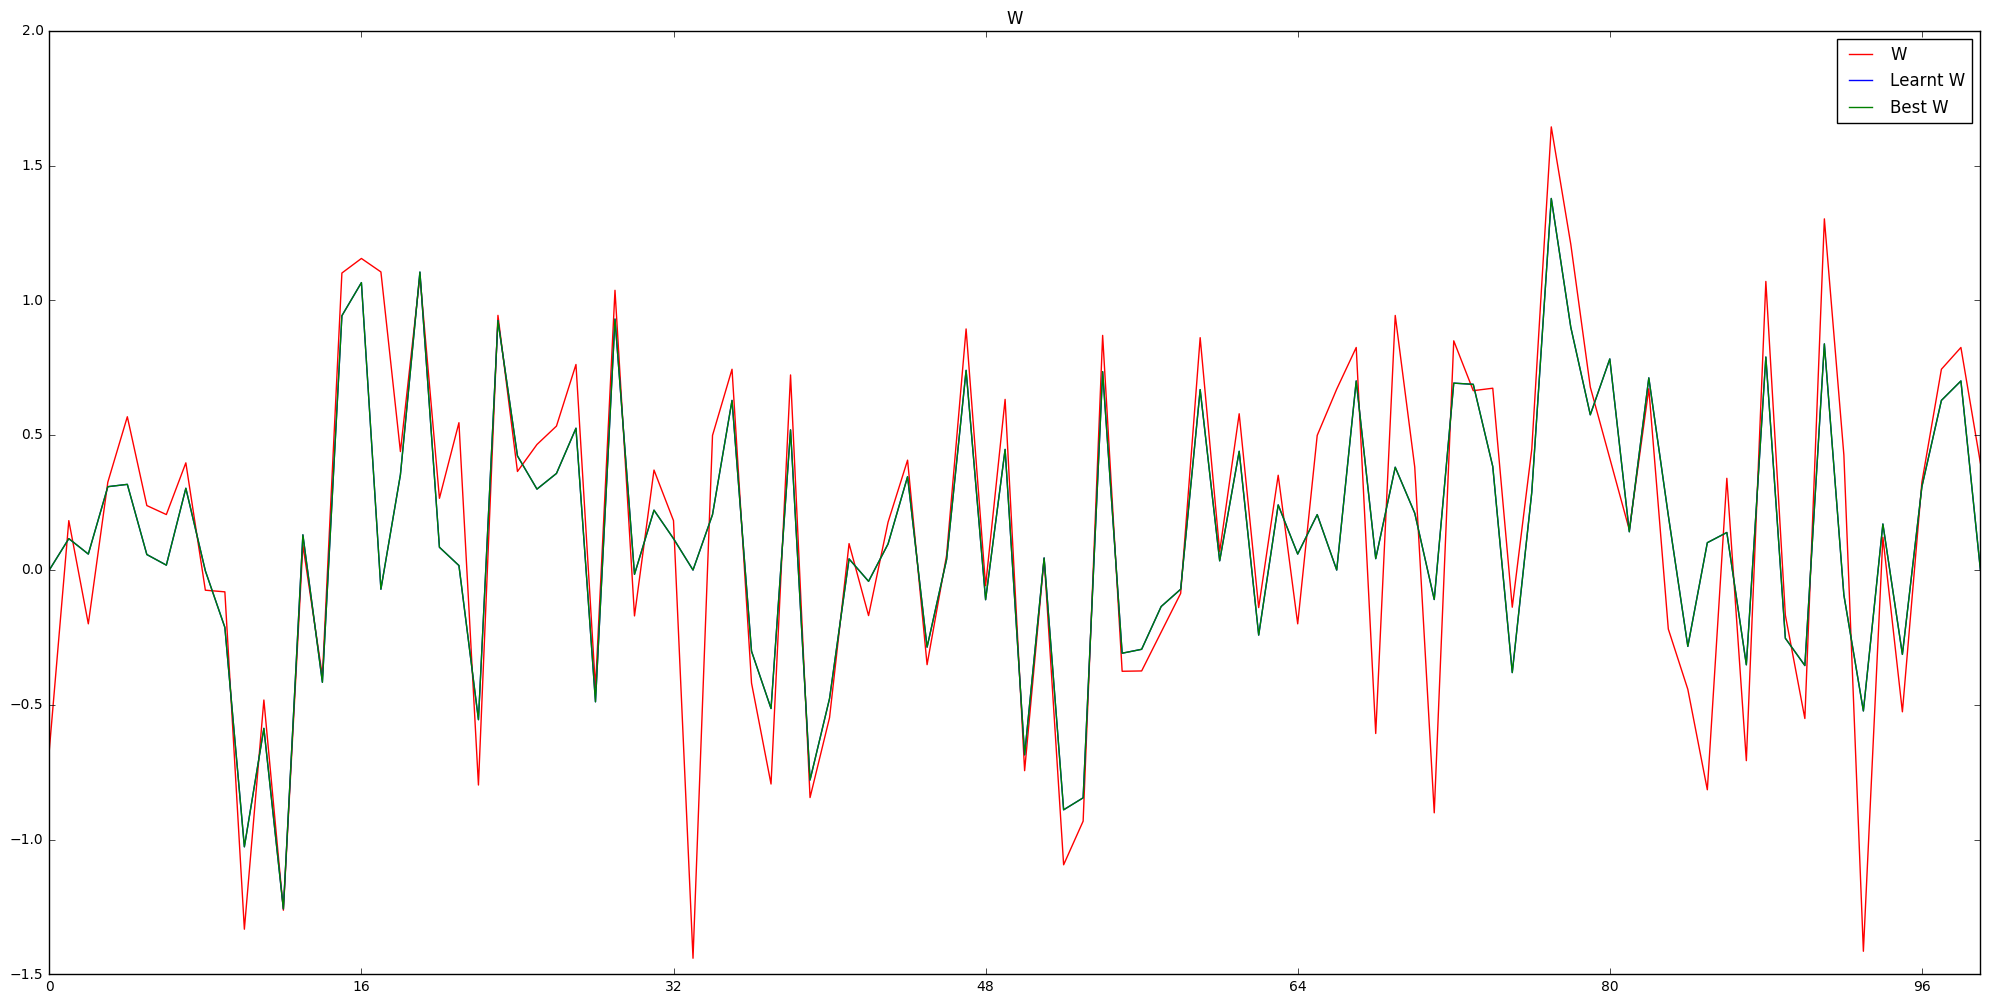

In [41]:
trainmpf(units = 32, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 32, temperature = 1, validate_every = 100, sample = '32-50K-nzd.npy')

########################MPF########################
2017-04-07 16:47:49.868306
Input size: 16
Learning temperature: 1
Learning rate: 0.01
Sample used: 16-50K-nzd.npy
Training epoch 0/1000, Cost: 1.209278 mseW: 0.02333, Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.643138 mseW: 0.00860, Time Elasped: 0.35 
Training epoch 200/1000, Cost: 0.642941 mseW: 0.00839, Time Elasped: 0.74 
Training epoch 300/1000, Cost: 0.642936 mseW: 0.00839, Time Elasped: 1.20 
Training epoch 400/1000, Cost: 0.642936 mseW: 0.00839, Time Elasped: 1.56 
Training epoch 500/1000, Cost: 0.642936 mseW: 0.00839, Time Elasped: 1.90 
Training epoch 600/1000, Cost: 0.642936 mseW: 0.00839, Time Elasped: 2.24 
Training epoch 700/1000, Cost: 0.642936 mseW: 0.00839, Time Elasped: 2.59 
Training epoch 800/1000, Cost: 0.642936 mseW: 0.00839, Time Elasped: 2.93 
Training epoch 900/1000, Cost: 0.642936 mseW: 0.00839, Time Elasped: 3.27 
The training took 3.62 minutes
######################Results######################
Bes

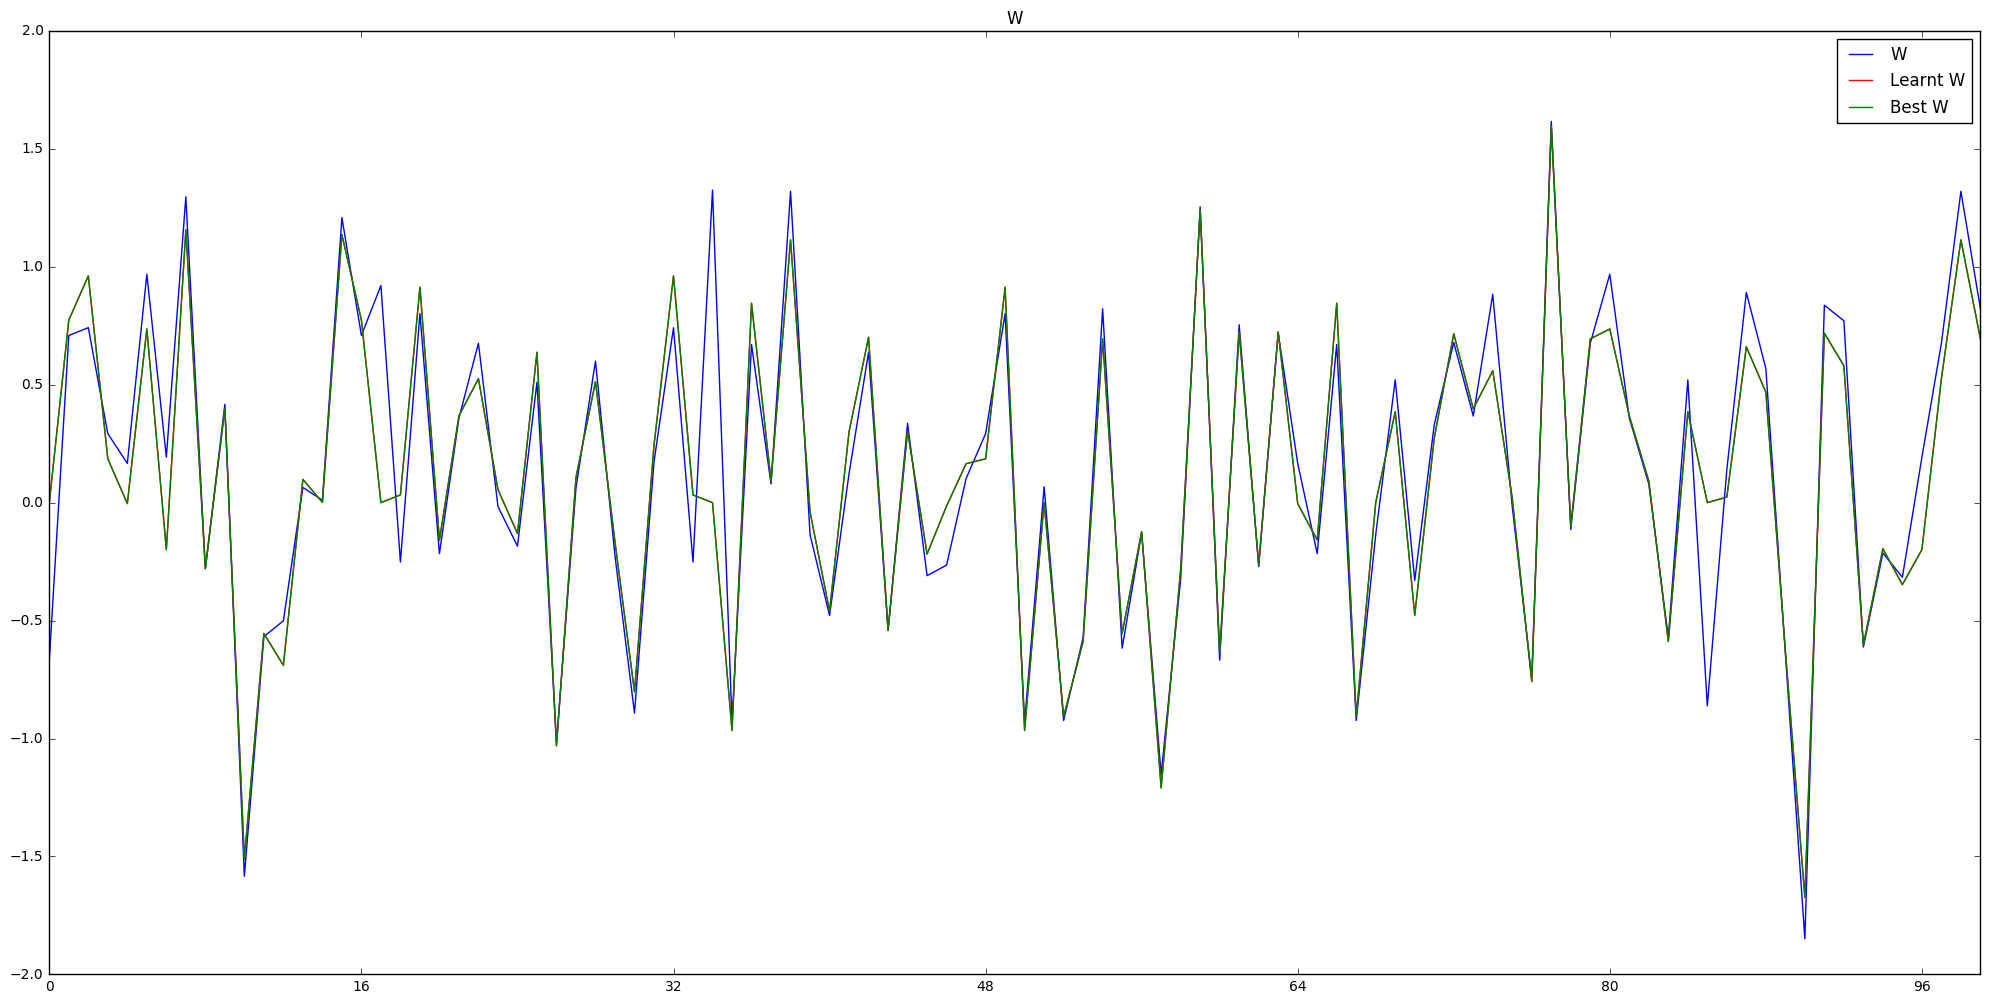

In [13]:
trainmpf(units = 16, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K-nzd.npy')

In [51]:
trainmpf(units = 32, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 32, temperature = 1, validate_every = 100, sample = '32-50K-nzd.npy')

########################MPF########################
2017-04-07 16:36:01.451894
Input size: 32
Learning temperature: 1
Learning rate: 0.01
Sample used: 32-50K-nzd.npy
Training epoch 0/1000, Cost: 2.585028 mseW: 0.01172, Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.202768 mseW: 0.01499, Time Elasped: 0.35 
Training epoch 200/1000, Cost: 0.133329 mseW: 0.01887, Time Elasped: 0.69 


KeyboardInterrupt: 